In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sn


def sigmoid(z):
    return 1/(1 + np.exp(-z))


# Produce a neutral network randomly initialized
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x)
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)
    b2 = np.zeros((n_y, 1))

    parameters = {
        "W1": W1,
        "b1" : b1,
        "W2": W2,
        "b2" : b2
    }
    return parameters


# Evaluate the neural network
def forward_prop(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Z value for Layer 1
    Z1 = np.dot(W1, X) + b1
    # Activation value for Layer 1
    A1 = np.tanh(Z1)
    # Z value for Layer 2
    Z2 = np.dot(W2, A1) + b2
    # Activation value for Layer 2
    A2 = sigmoid(Z2)

    cache = {
        "A1": A1,
        "A2": A2
    }
    return A2, cache


# Evaluate the error (i.e., cost) between the prediction made in A2 and the provided labels Y 
# We use the Mean Square Error cost function
def calculate_cost(A2, Y, m):
    # m is the number of examples
    cost = np.sum((0.5 * (A2 - Y) ** 2).mean(axis=1))/m
    return cost


# Apply the backpropagation
def backward_prop(X, Y, cache, parameters, m):
    A1 = cache["A1"]
    A2 = cache["A2"]

    W2 = parameters["W2"]

    # Compute the difference between the predicted value and the real values
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T)/m
    db2 = np.sum(dZ2, axis=1, keepdims=True)/m
    # Because d/dx tanh(x) = 1 - tanh^2(x)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1-np.power(A1, 2))
    dW1 = np.dot(dZ1, X.T)/m
    db1 = np.sum(dZ1, axis=1, keepdims=True)/m

    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }

    return grads


# Third phase of the learning algorithm: update the weights and bias
def update_parameters(parameters, grads, learning_rate):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
  
    new_parameters = {
        "W1": W1,
        "W2": W2,
        "b1" : b1,
        "b2" : b2
    }

    return new_parameters


# model is the main function to train a model
# X: is the set of training inputs
# Y: is the set of training outputs
# n_x: number of inputs (this value impacts how X is shaped)
# n_h: number of neurons in the hidden layer
# n_y: number of neurons in the output layer (this value impacts how Y is shaped)
def model(X, Y, n_x, n_h, n_y, num_of_iters, learning_rate, m):
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    cost_values = []
    
    for i in range(0, num_of_iters+1):
        a2, cache = forward_prop(X, parameters)
        cost = calculate_cost(a2, Y, m)
        
        cost_values.append(cost)
        
        grads = backward_prop(X, Y, cache, parameters, m)
        parameters = update_parameters(parameters, grads, learning_rate)
        #if(i%100 == 0):
        #    print('Cost after iteration# {:d}: {:f}'.format(i, cost))

    return parameters, cost_values


# Make a prediction
# X: represents the inputs
# parameters: represents a model
# the result is the prediction
def predict(X, parameters):
    a2, cache = forward_prop(X, parameters)
    yhat = a2
    yhat = np.squeeze(yhat)
    for i in range(0, len(yhat)):
        if(yhat[i] >= 0.5):
            yhat[i] = 1
        else:
            yhat[i] = 0
    '''if(yhat >= 0.5):
        y_predict = 1
    else:
        y_predict = 0'''

    #return y_predict
    return yhat


# Normalizes the data
# df: represents the dataframe to normalize
# The result is the dataframe normalized
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


# Computes a confusion matrix
# true: represents the true labels
# pred: represents the labels predicted
# Returns a confusion matrix
def compute_confusion_matrix(true, pred):
    """Computes a confusion matrix using numpy for two np.arrays
    true and pred.

    Results are identical (and similar in computation time) to:
    "from sklearn.metrics import confusion_matrix"

    However, this function avoids the dependency on sklearn."""

    K = len(np.unique(true))  # Number of classes
    result = np.zeros((K, K))

    for i in range(len(true)):
        result[true[i]][pred[i]] += 1

    return result.astype(int)


# Implementation of cross-validation
# features: data containing the features
# labels: data containing the labels
# k: number of folds to be produced
# seed: seed to use for random choices
# Plots the cost function for every fold,
# Prints the precision, recall and f1 scores for every fold,
# Plots the confusion matrixes for every fold tested
def cross_validation(features, labels, k, seed=42):
    np.random.seed(seed)
    features, labels = shuffle(features, labels)
    # length = int(data_x.shape[0]/k)
    # print("SIZE OF DATA: ", data_x.shape[0])

    fold_x = np.array_split(features, k)
    fold_y = np.array_split(labels, k)

    matrixes = []
    all_cost_values = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for i in range(k):
        X_test_f = fold_x[i]
        y_test_f = fold_y[i]

        X_train_folds = np.delete(fold_x, i)
        y_train_folds = np.delete(fold_y, i)

        m = X_train_folds[0].shape[0]

        trained_parameters, cost_values = model(X_train_folds[0].transpose(), y_train_folds[0], n_x, n_h, n_y,
                                                number_of_iterations, learning_rate, m)
        y_predict = predict(X_test_f.transpose(), trained_parameters)
        conf_matrix = compute_confusion_matrix(y_test_f.astype(int), y_predict.astype(int))
        precision_scores.append(precision_score(y_test_f.astype(int), y_predict.astype(int), average="macro"))
        recall_scores.append(recall_score(y_test_f.astype(int), y_predict.astype(int), average="macro"))
        f1_scores.append(f1_score(y_test_f.astype(int), y_predict.astype(int), average="macro"))
        matrixes.append(conf_matrix)
        all_cost_values.append(cost_values)

    for i, cost in enumerate(all_cost_values):
        iteration = list(range(len(cost)))
        title = 'Cost function v/s Training iteration'
        plt.title(title, loc='center', pad=20.0)
        plt.plot(iteration, cost, label='Tested with fold n°' + str(i + 1))
        plt.legend()
        plt.xlabel('Training iteration')
        plt.ylabel('Cost function')

    plt.show()

    for n, every_score in enumerate(zip(precision_scores, recall_scores, f1_scores)):
        print('Results of testing in fold number {:d}:'
              '\nPrecision score: {:.2f}\nRecall score: {:.2f}\nF1 score: {:.2f}\n\n'.format(
                n + 1, every_score[0], every_score[1], every_score[2]))

    for i, matrix in enumerate(matrixes):
        df_cm = pd.DataFrame(matrix, index=[i for i in "01"],
                             columns=[i for i in "01"])
        plt.figure(figsize=(8, 5))
        ax = plt.axes()
        ax.set_title('Confusion matrix for fold {:d}'.format(i + 1), fontsize=18, pad=20.0)
        sn.heatmap(df_cm, annot=True, cmap="Blues")
        ax.set_ylabel('Predicted label', fontsize=12)
        ax.set_xlabel('True label', fontsize=12)
        plt.show()

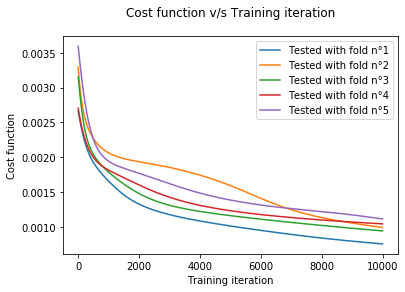

Results of testing in fold number 1:
Precision score: 0.75
Recall score: 0.73
F1 score: 0.73


Results of testing in fold number 2:
Precision score: 0.63
Recall score: 0.63
F1 score: 0.63


Results of testing in fold number 3:
Precision score: 0.74
Recall score: 0.80
F1 score: 0.75


Results of testing in fold number 4:
Precision score: 0.76
Recall score: 0.72
F1 score: 0.74


Results of testing in fold number 5:
Precision score: 0.68
Recall score: 0.71
F1 score: 0.68




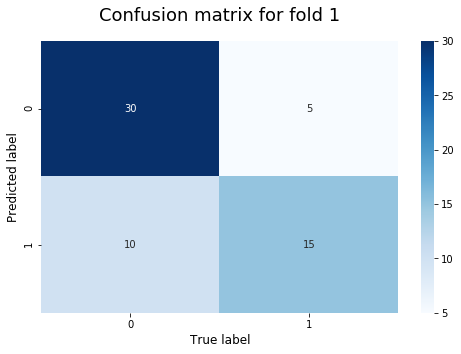

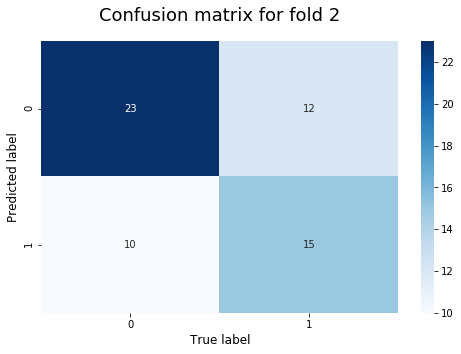

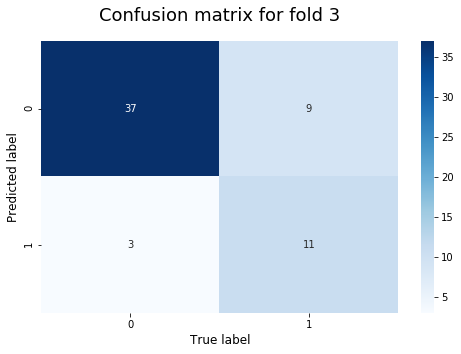

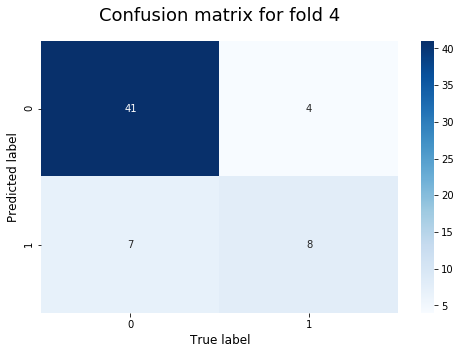

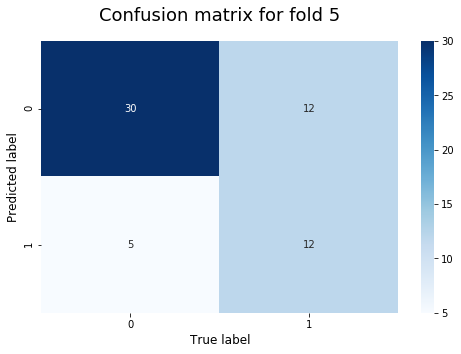

In [2]:
# Read and load the data from the direct URL into a dataframe, 
# and then we perfom a normalization
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv')
data = normalize(data)

# Divide the data between features and labels
data_wo_death = data.drop('DEATH_EVENT', 1)
data_y = data['DEATH_EVENT'].to_numpy()
data_x = data_wo_death.to_numpy()

# Set the hyperparameters
n_x = 12  # No. of neurons in first layer
n_h = 4  # No. of neurons in hidden layer
n_y = 1  # No. of neurons in output layer

# The number of times the model has to learn the dataset
number_of_iterations = 10000
learning_rate = 0.01

# Number of folds to perform the cross-validation
n_folds = 5
        
cross_validation(data_x, data_y, n_folds)